# Diversity vs. Similarity

This notebook examines two ways of measuring diversity. The first is the diversity
metric from the `divintseg` package. This measures the probability of a person living
in an area encountering a person from a different racial or ethnic group. The second is 
similarity to the overall United States population. Under this measure, areas whose 
distribution of racial and ethnic groups closely resembles that of the country as a whole
score highest. Support for computing similarity was recently added to `divintseg`.

# 0. Imports and configuration

In [1]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC, AK, NJ
from censusdis import states

import divintseg as dis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
# Fill in your own key here, or leave as is
# if you are doing low volume queries that
# will not hit the census server usage limits.
CENSUS_API_KEY = None

# 1. Identify the dataset and variables we will use

In [3]:
DATASET = "acs/acs5"
YEAR = 2020

In [4]:
GROUP = "B03002"

HISPANIC_LATINO_VARIABLE = f'{GROUP}_012E'

In [5]:
df_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)
df_variables

YEAR   DATASET   GROUP     VARIABLE  \
0   2020  acs/acs5  B03002  B03002_001E   
1   2020  acs/acs5  B03002  B03002_002E   
2   2020  acs/acs5  B03002  B03002_003E   
3   2020  acs/acs5  B03002  B03002_004E   
4   2020  acs/acs5  B03002  B03002_005E   
5   2020  acs/acs5  B03002  B03002_006E   
6   2020  acs/acs5  B03002  B03002_007E   
7   2020  acs/acs5  B03002  B03002_008E   
8   2020  acs/acs5  B03002  B03002_009E   
9   2020  acs/acs5  B03002  B03002_010E   
10  2020  acs/acs5  B03002  B03002_011E   
11  2020  acs/acs5  B03002  B03002_012E   
12  2020  acs/acs5  B03002  B03002_013E   
13  2020  acs/acs5  B03002  B03002_014E   
14  2020  acs/acs5  B03002  B03002_015E   
15  2020  acs/acs5  B03002  B03002_016E   
16  2020  acs/acs5  B03002  B03002_017E   
17  2020  acs/acs5  B03002  B03002_018E   
18  2020  acs/acs5  B03002  B03002_019E   
19  2020  acs/acs5  B03002  B03002_020E   
20  2020  acs/acs5  B03002  B03002_021E   

                                                LABEL  SUGGESTED_WEIGHT VALUES  
0                                    Estimate!!Total:               NaN   None  
1           Estimate!!Total:!!Not Hispanic or Latino:               NaN   None  
2   Estimate!!Total:!!Not Hispanic or Latino:!!Whi...               NaN   None  
3   Estimate!!Total:!!Not Hispanic or Latino:!!Bla...               NaN   None  
4   Estimate!!Total:!!Not Hispanic or Latino:!!Ame...               NaN   None  
5   Estimate!!Total:!!Not Hispanic or Latino:!!Asi...               NaN   None  
6   Estimate!!Total:!!Not Hispanic or Latino:!!Nat...               NaN   None  
7   Estimate!!Total:!!Not Hispanic or Latino:!!Som...               NaN   None  
8   Estimate!!Total:!!Not Hispanic or Latino:!!Two...               NaN   None  
9   Estimate!!Total:!!Not Hispanic or Latino:!!Two...               NaN   None  
10  Estimate!!Total:!!Not Hispanic or Latino:!!Two...               NaN   None  
11              Estimate!!Total:!!Hispanic or Latino:               NaN   None  
12  Estimate!!Total:!!Hispanic or Latino:!!White a...               NaN   None  
13  Estimate!!Total:!!Hispanic or Latino:!!Black o...               NaN   None  
14  Estimate!!Total:!!Hispanic or Latino:!!America...               NaN   None  
15  Estimate!!Total:!!Hispanic or Latino:!!Asian a...               NaN   None  
16  Estimate!!Total:!!Hispanic or Latino:!!Native ...               NaN   None  
17  Estimate!!Total:!!Hispanic or Latino:!!Some ot...               NaN   None  
18  Estimate!!Total:!!Hispanic or Latino:!!Two or ...               NaN   None  
19  Estimate!!Total:!!Hispanic or Latino:!!Two or ...               NaN   None  
20  Estimate!!Total:!!Hispanic or Latino:!!Two or ...               NaN   None

In [6]:
group_leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

In [7]:
# Leaves of the group if we prune the tree at 
# HISPANIC_LATINO_VARIABLE and don't go down 
# that side of the tree.
race_or_hl_leaves = (
    [leaf for leaf in group_leaves if leaf < HISPANIC_LATINO_VARIABLE] + 
    [HISPANIC_LATINO_VARIABLE]
)

Now we can decide which set of variables we want as leaves. 
Uncomment one or the other.

In [8]:
#leaves = group_leaves
leaves = race_or_hl_leaves

leaves

['B03002_003E',
 'B03002_004E',
 'B03002_005E',
 'B03002_006E',
 'B03002_007E',
 'B03002_008E',
 'B03002_010E',
 'B03002_011E',
 'B03002_012E']

In [9]:
leaf_names = {
    leaf: df_variables[df_variables['VARIABLE'] == leaf]['LABEL'].iloc[0].split('!!')[-1].split(':')[0]
    for leaf in leaves
}

leaf_names

{'B03002_003E': 'White alone',
 'B03002_004E': 'Black or African American alone',
 'B03002_005E': 'American Indian and Alaska Native alone',
 'B03002_006E': 'Asian alone',
 'B03002_007E': 'Native Hawaiian and Other Pacific Islander alone',
 'B03002_008E': 'Some other race alone',
 'B03002_010E': 'Two races including Some other race',
 'B03002_011E': 'Two races excluding Some other race, and three or more races',
 'B03002_012E': 'Hispanic or Latino'}

# 2. Download the data

In [10]:
%%time

df_tract = ced.download(
    DATASET,
    YEAR,
    ['NAME'] + leaves,
    state=ALL_STATES_AND_DC,
    tract="*",
    api_key=CENSUS_API_KEY,
)

CPU times: user 509 ms, sys: 102 ms, total: 611 ms
Wall time: 5.83 s


In [11]:
df_tract.shape

(84414, 13)

In [12]:
# Drop tracts with tiny population.
df_tract = df_tract[df_tract[leaves].sum(axis='columns') >= 100].copy()

In [13]:
df_tract.shape

(83479, 13)

In [14]:
df_us = ced.download(
    DATASET,
    YEAR,
    leaves,
    us="*",
    api_key=CENSUS_API_KEY,
)

In [15]:
df_us

US  B03002_003E  B03002_004E  B03002_005E  B03002_006E  B03002_007E  \
0  1    196251375     39994653      2075852     18184182       550080   

   B03002_008E  B03002_010E  B03002_011E  B03002_012E  
0      1017604       827762      8306780     59361020

In [16]:
# Nationwide white fraction.
float(df_us['B03002_003E'] / df_us[leaves].sum(axis='columns'))

0.600948620070567

In [17]:
df_tract['total'] = df_tract[leaves].sum(axis='columns')

for leaf in leaves:
    df_tract[f'frac_{leaf}'] = df_tract[leaf] / df_tract['total']

In [18]:
df_tract['max_col'] = df_tract[leaves].idxmax(axis='columns')

In [19]:
df_tract.columns

Index(['STATE', 'COUNTY', 'TRACT', 'NAME', 'B03002_003E', 'B03002_004E',
       'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E',
       'B03002_010E', 'B03002_011E', 'B03002_012E', 'total',
       'frac_B03002_003E', 'frac_B03002_004E', 'frac_B03002_005E',
       'frac_B03002_006E', 'frac_B03002_007E', 'frac_B03002_008E',
       'frac_B03002_010E', 'frac_B03002_011E', 'frac_B03002_012E', 'max_col'],
      dtype='object')

# 3. Compute Similarity and Diversity

In [20]:
dissim = dis.dissimilarity(
    df_communities=df_tract[leaves],
    reference=df_us[leaves]
)

In [21]:
df_tract['dissimilarity'] = dissim
df_tract['representation'] = 1 - dissim

In [22]:
df_tract.head()

STATE COUNTY   TRACT                                            NAME  \
0    28    049  010103  Census Tract 101.03, Hinds County, Mississippi   
1    28    049  010104  Census Tract 101.04, Hinds County, Mississippi   
2    28    049  010201  Census Tract 102.01, Hinds County, Mississippi   
3    28    049  010202  Census Tract 102.02, Hinds County, Mississippi   
4    28    049  010203  Census Tract 102.03, Hinds County, Mississippi   

   B03002_003E  B03002_004E  B03002_005E  B03002_006E  B03002_007E  \
0          722         3919            0            8            0   
1         1053         1023            0            8            0   
2          171         3029           31            0            0   
3          318         4797           14           12            0   
4           85         2341            0            0            0   

   B03002_008E  ...  frac_B03002_005E  frac_B03002_006E  frac_B03002_007E  \
0            0  ...          0.000000          0.001720               0.0   
1            0  ...          0.000000          0.003707               0.0   
2            0  ...          0.009571          0.000000               0.0   
3            0  ...          0.002707          0.002320               0.0   
4           14  ...          0.000000          0.000000               0.0   

   frac_B03002_008E  frac_B03002_010E  frac_B03002_011E  frac_B03002_012E  \
0          0.000000               0.0          0.000215          0.000000   
1          0.000000               0.0          0.000000          0.034291   
2          0.000000               0.0          0.000000          0.002470   
3          0.000000               0.0          0.005994          0.000000   
4          0.005738               0.0          0.000000          0.000000   

       max_col  dissimilarity  representation  
0  B03002_004E       0.720327        0.279673  
1  B03002_003E       0.351581        0.648419  
2  B03002_004E       0.815910        0.184090  
3  B03002_004E       0.805025        0.194975  
4  B03002_004E       0.839579        0.160421  

[5 rows x 26 columns]

In [23]:
diversity = dis.diversity(df_tract[leaves])
df_tract['diversity'] = diversity

# 4. Calder Plots

## Helper Functions for Plotting

In [24]:
def scatter_all(df_tract, color='lightgrey', ax=None):
    ax = df_tract.plot.scatter(
        'representation', 'diversity', s=0.2, c=color,
        ax=ax,
        figsize=(10, 8)
    )

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.grid()
    
    return ax


def first_row_name(df):
    name = df['NAME'].iloc[0]
    name = (
        f'{name}\n'
        f'{100 * df["representation"].iloc[0]:.1f}% similarity; '
        f'{100 * df["diversity"].iloc[0]:.1f}% diversity; '
    )
    
    return name


def plot_hilight(df, ax, color):

    name = first_row_name(df)

    df.plot.scatter(
        'representation', 'diversity', 
        s=50, c='#0000', edgecolor=color, linewidth=2,
        label=name,
        ax=ax
    )

def plot_bar_selected(df_selected_points):

    df_selected_points['label'] = df_selected_points['NAME'].apply(
        lambda name: name.replace(',', '\n', 1).replace(',', ',\n').replace('Census Tract ', 'Tract ').replace(
            ' Municipality', '\nMunicipality'
        ).replace(
            ' County', '\nCounty'
        )
    )
    df_selected_points = df_selected_points.set_index('label')
    df_selected_points = df_selected_points[[f'frac_{leaf}' for leaf in leaves]].rename(
        {
            f'frac_{leaf}': f'Percent {leaf_names[leaf]}'
            for leaf in leaves
        },
        axis='columns'
    )
    
    ax = df_selected_points.plot.bar(
        figsize=(12, 6),
    )
    ax.grid(axis='y')
    plt.xticks(rotation=0)
    ax.set_xlabel(None)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
    
    ax.set_ylim(0, 1)
    return ax

## All Tracts

A scatter plot of diversity vs. similarity for all census tracts with a population
of 100+ in the U.S.

The shape is a bit unusual. It looks to me like it could be the profile of a sculpture 
by Alexander Calder. So I nickname this kind of plot a *Calder plot*.

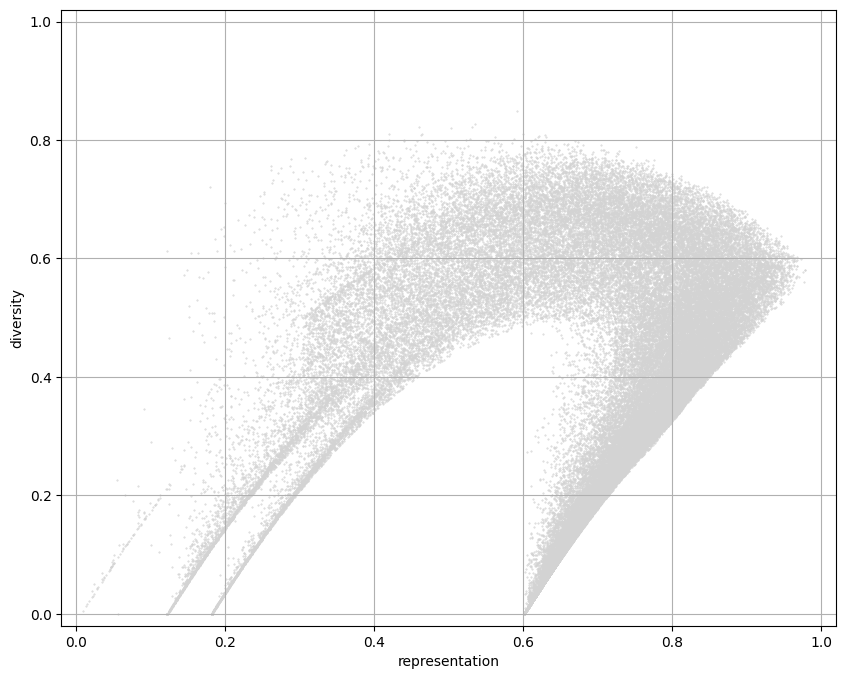

In [25]:
ax = scatter_all(df_tract)

## Colors in the Legs

It isn't immediately obvious what the legs of the plot are an what they represent.
But if we color in some of the most homogenous tracts in the country, where one
racial or ethnic group represents 80% or more of the population, we see something
interesting. Each leg consists of the tracts dominated by a different group.

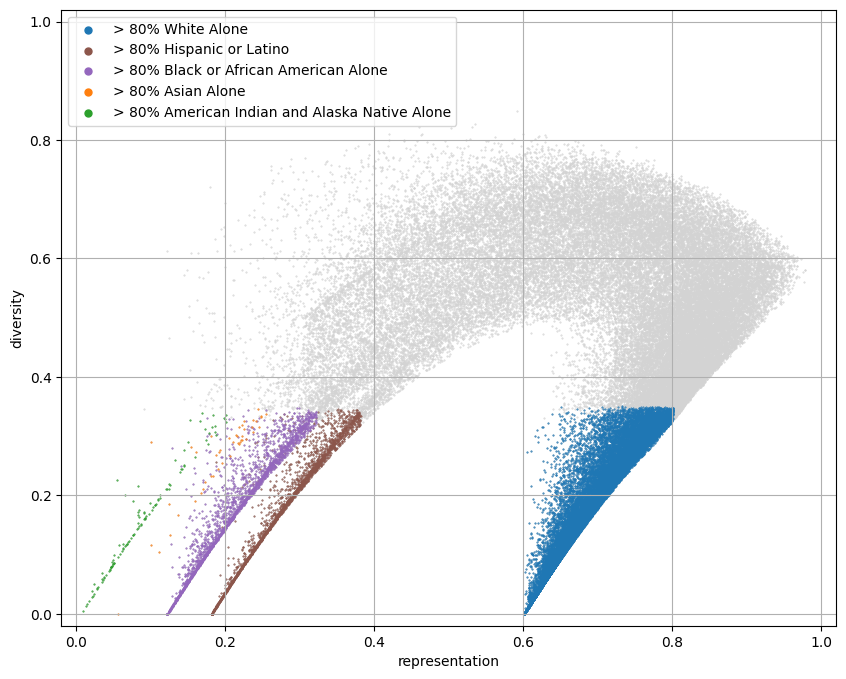

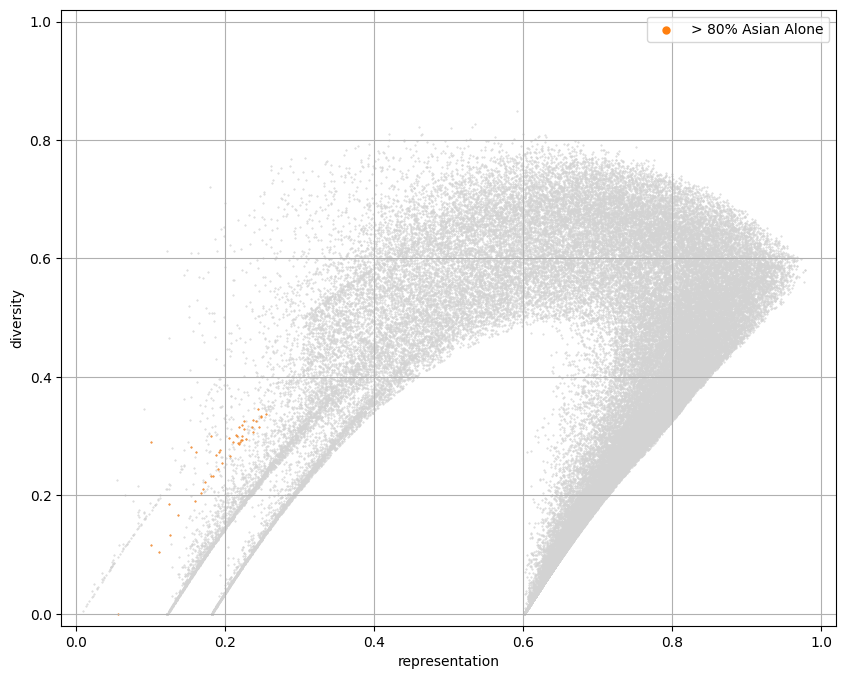

In [26]:
threshold = 0.8

graph_colors = [
    [
        (0, 'C0'),
        (-1, 'C5'),
        (1, 'C4'),
        (3, 'C1'),
        (2, 'C2'),
    ],
    [
        (3, 'C1'),
    ]
]

for colors in graph_colors:
    ax = scatter_all(df_tract)

    for ii, color in colors:
        ax = df_tract[df_tract[f'frac_{leaves[ii]}'] > threshold].plot.scatter(
            'representation', 'diversity', s=0.2, c=color,
            label=f'> {threshold * 100:.0f}% {leaf_names[leaves[ii]]}'.title().replace('Or', 'or').replace('And', 'and'),
            ax=ax,
        )

    legend = ax.legend()
    for handle in legend.legend_handles:
        handle._sizes = [25]
        
    ax.grid()

## Tips of the Legs

Let's look at the tips of the legs. Each one is a 100% or nearly
100% homogeneous, which leads to zero or near zero diversity.

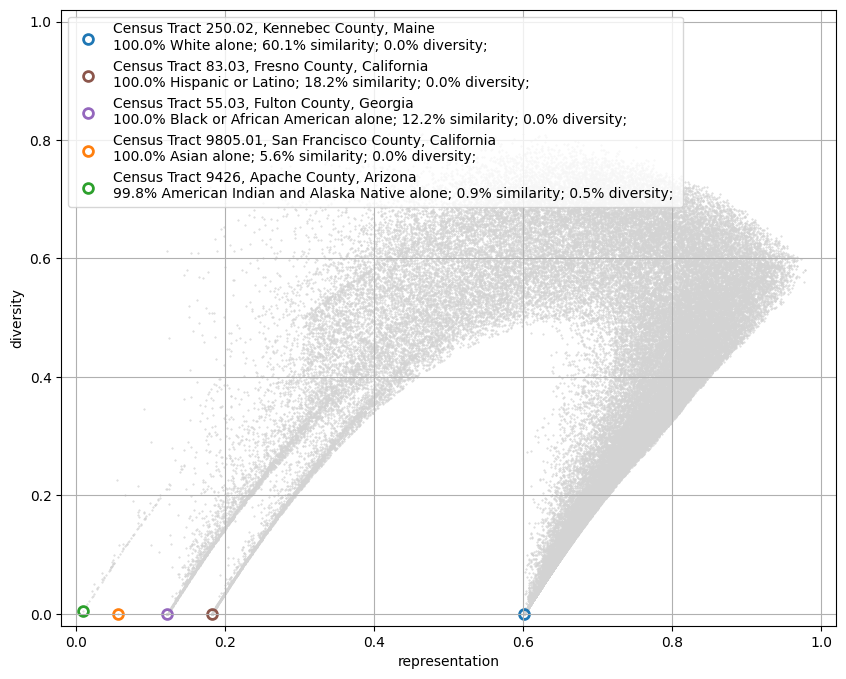

In [27]:
ax = scatter_all(df_tract)

for ii, color in graph_colors[0]:
    
    df_extreme = df_tract[df_tract['max_col'] == leaves[ii]].nsmallest(
        100, 'diversity'
    ).nsmallest(
        1, 'representation'
    )

    frac = df_extreme[f'frac_{leaves[ii]}'].iloc[0]
    
    name = df_extreme['NAME'].iloc[0]
    name = (
        f'{name}\n'
        f'{100 * frac:.1f}% {leaf_names[leaves[ii]]}; '
        f'{100 * df_extreme["representation"].iloc[0]:.1f}% similarity; '
        f'{100 * df_extreme["diversity"].iloc[0]:.1f}% diversity; '
    )
    
    df_extreme.plot.scatter(
        'representation', 'diversity', 
        s=50, c='#0000', edgecolor=color, linewidth=2,
        label=name,
        ax=ax
    )
    
ax.grid()

## Maximum Representation and Others at Similar Diversity (58% Diversity Cut)

Next, consider the most representative point and a series of other points that
are very near the same diversity, but very different similarities.

In [28]:
ax = scatter_all(df_tract)

df_max = df_tract.nlargest(1, 'representation')

diversity = df_max["diversity"].iloc[0]

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'representation')

rep = (df_max["representation"].iloc[0] + df_min["representation"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['representation'] > rep - 0.002) &
    (df_tract['representation'] < rep + 0.002)
].nsmallest(1, 'representation')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')
    
ax.grid()

In [29]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

<Axes: >

## 75% Diversity Cut

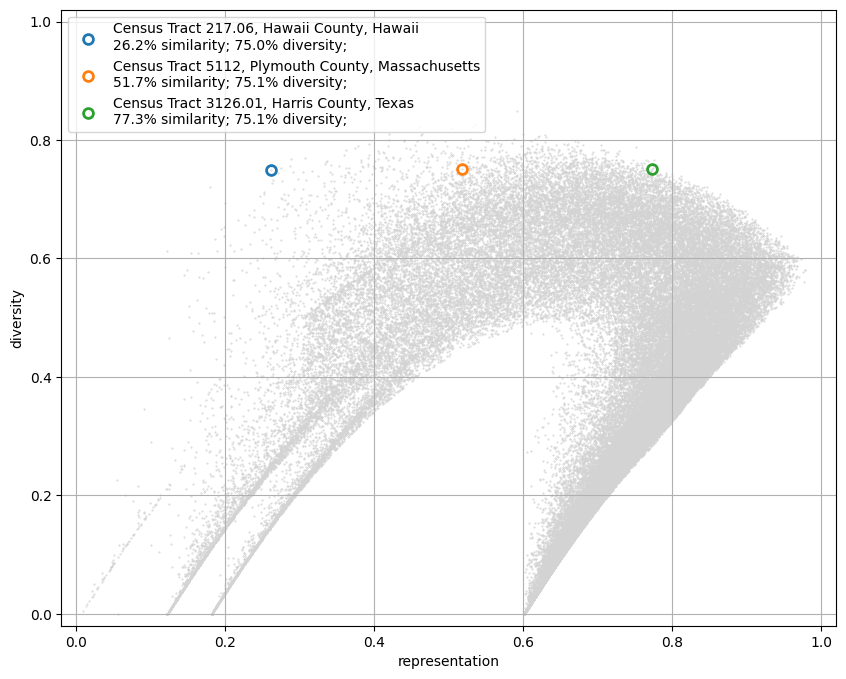

In [30]:
ax = scatter_all(df_tract)

diversity = 0.75

df_max = df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'representation')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'representation')

rep = (df_max["representation"].iloc[0] + df_min["representation"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['representation'] > rep - 0.002) &
    (df_tract['representation'] < rep + 0.002)
].nsmallest(1, 'representation')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

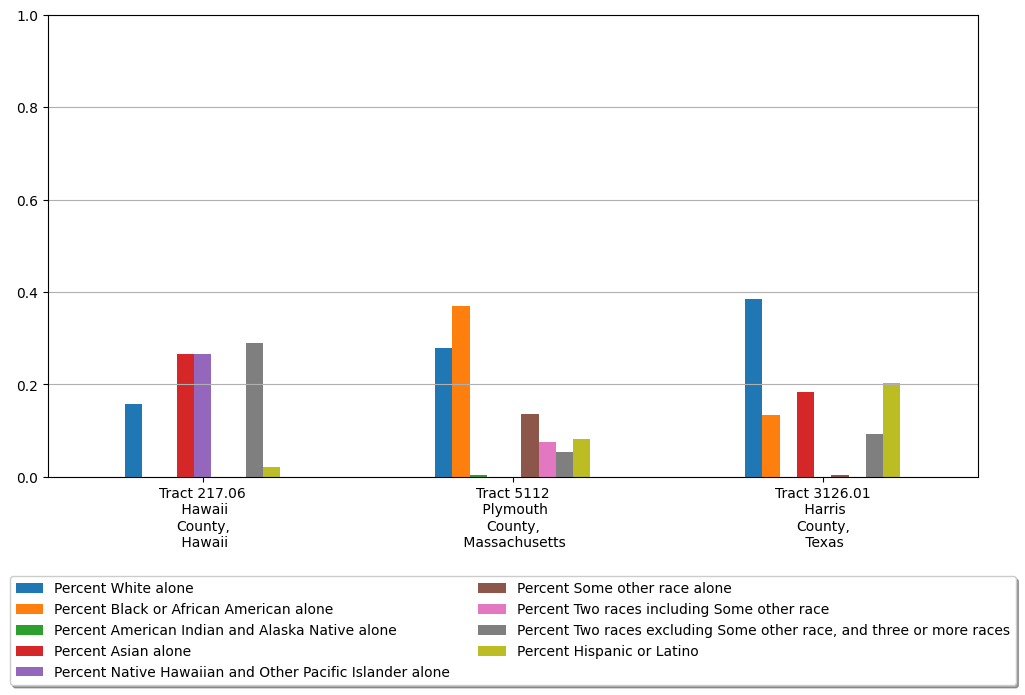

In [31]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 25% Diversity Cut

In [32]:
ax = scatter_all(df_tract)

diversity = 0.25

df_max = df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'representation')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'representation')

rep = (df_max["representation"].iloc[0] + df_min["representation"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['representation'] > 0.3) &
    (df_tract['representation'] < 0.4)
].nlargest(1, 'representation')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

In [33]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

<Axes: >

## 50% Diversity Cut

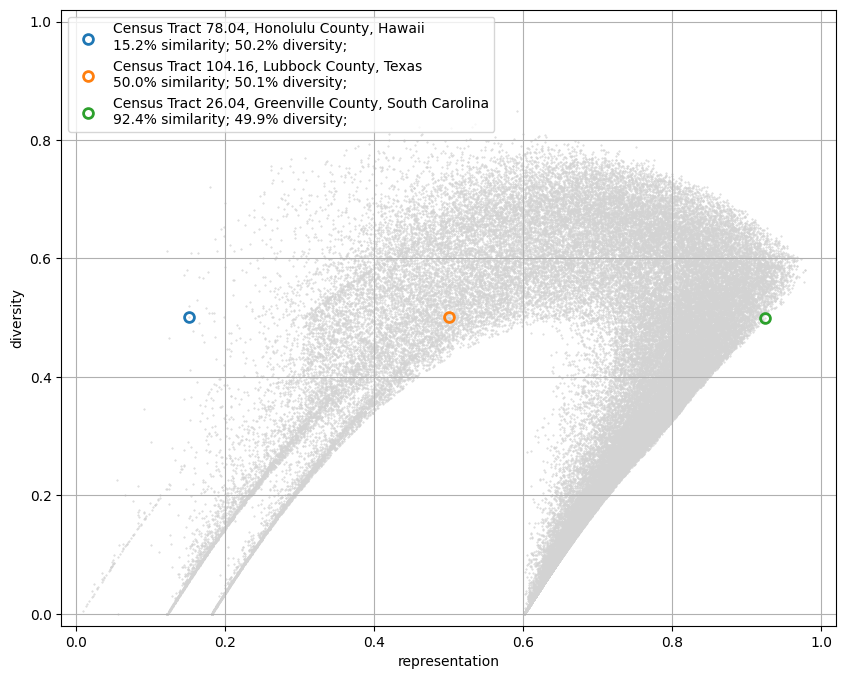

In [34]:
ax = scatter_all(df_tract)

diversity = 0.5

df_max = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'representation')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'representation')

rep = (df_max["representation"].iloc[0] + df_min["representation"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['representation'] > 0.4) &
    (df_tract['representation'] < 0.5)
].nlargest(1, 'representation')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

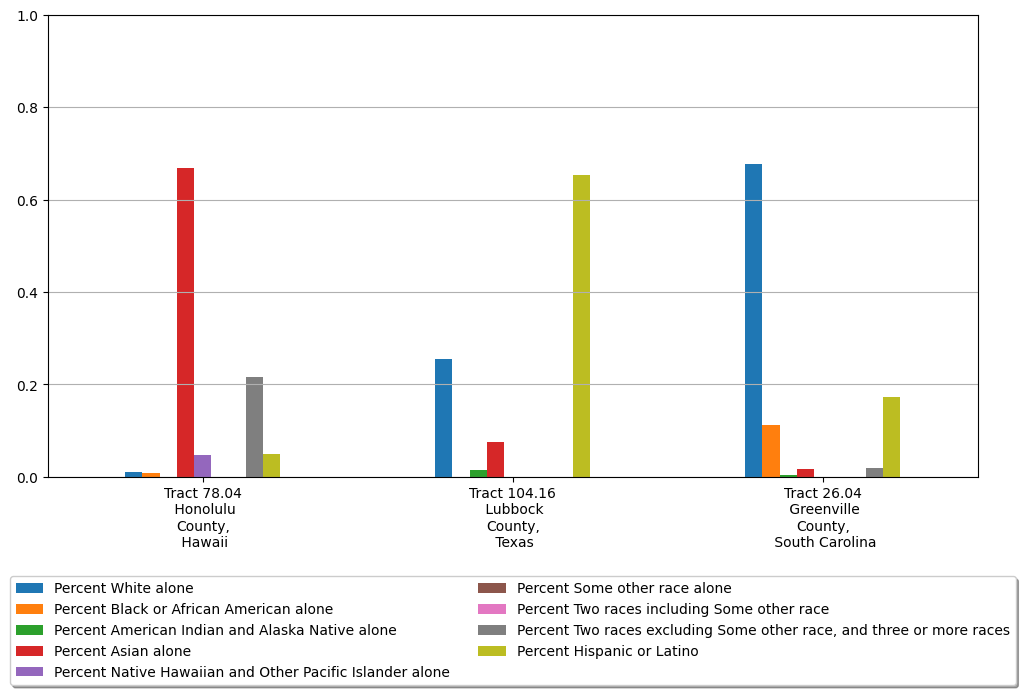

In [35]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## Tip of the White Leg and Others at Similar Similarity (60% Similarity Cut)

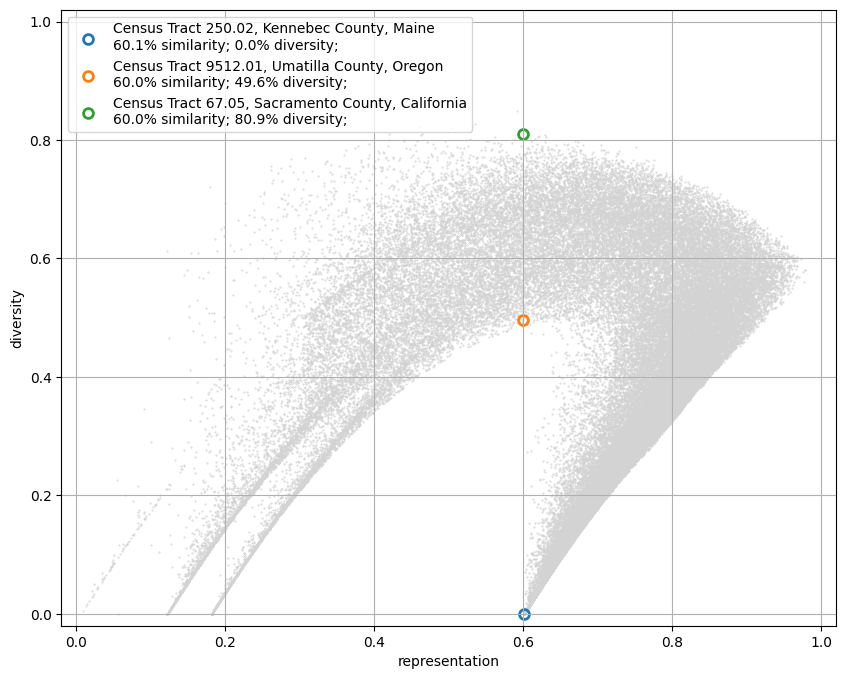

In [36]:
ax = scatter_all(df_tract)

df_min = df_tract[df_tract['max_col'] == leaves[0]].nsmallest(
    1, 'diversity'
)

representation = df_min['representation'].iloc[0]

df_max = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nlargest(1, 'diversity')

df_mid = df_tract[
    (df_tract['diversity'] > 0.4) &
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nsmallest(1, 'diversity')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

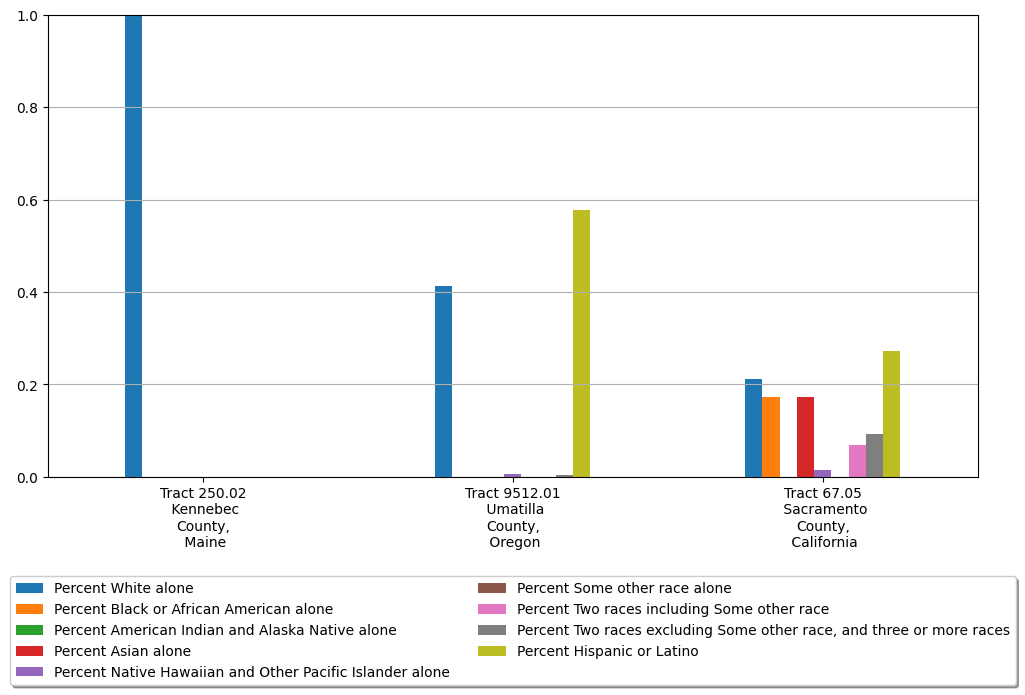

In [37]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 75% Similarity Cut

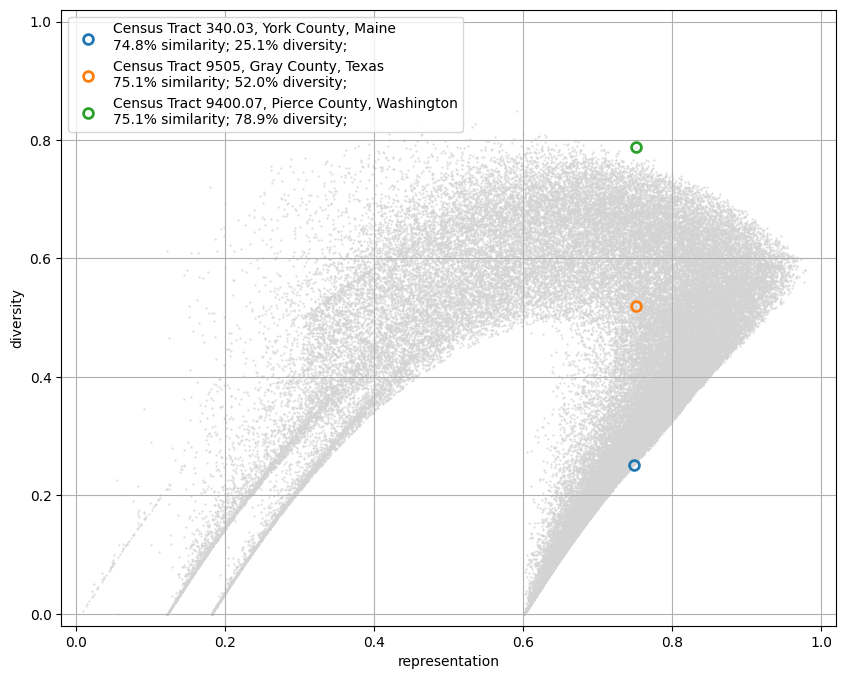

In [38]:
ax = scatter_all(df_tract)

representation = 0.75

df_max = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002) &
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

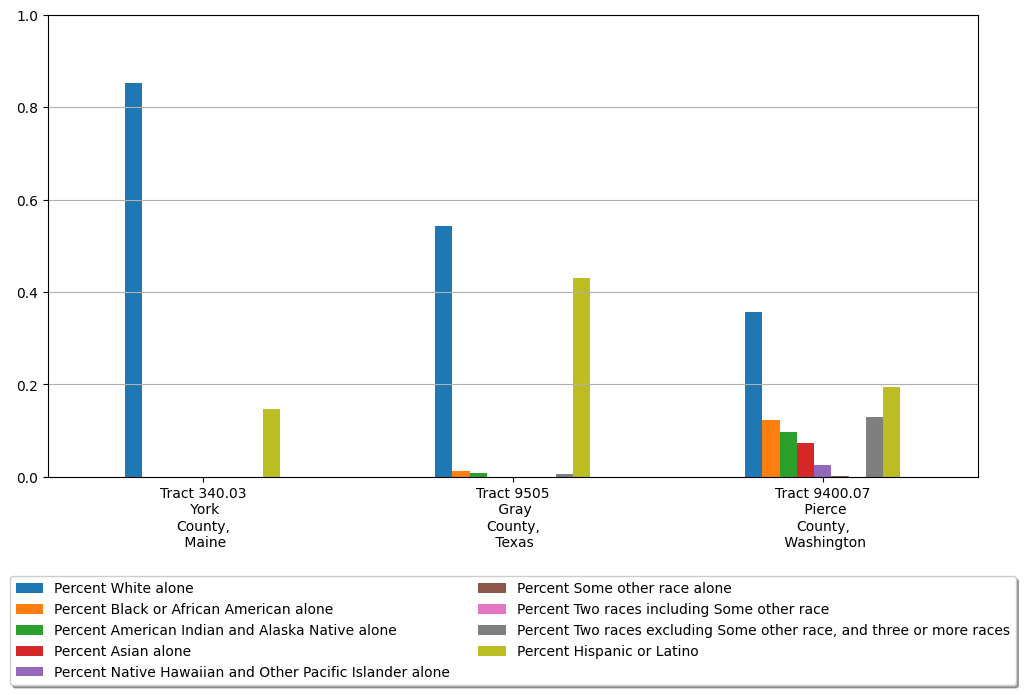

In [39]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 50% Similarity Cut

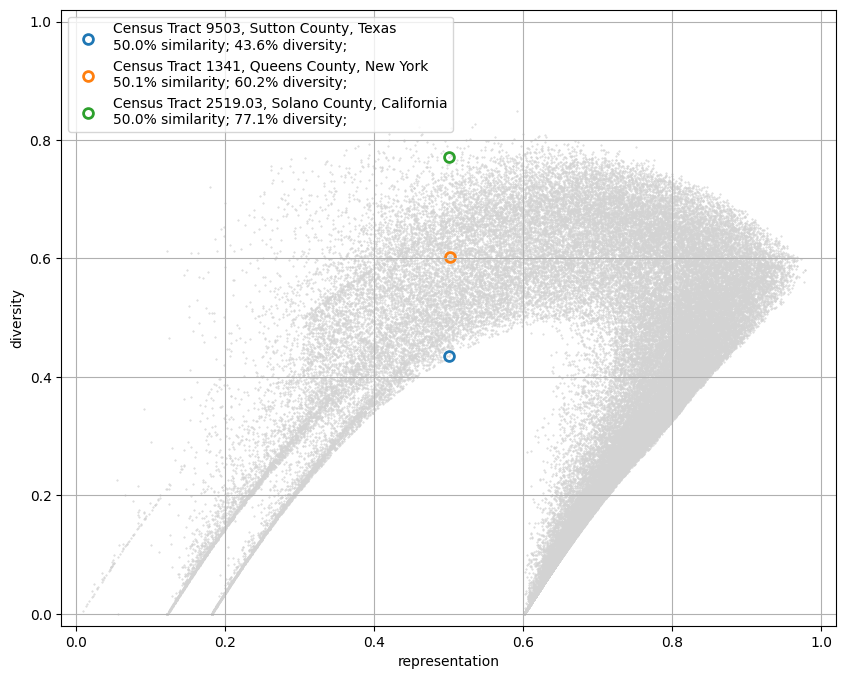

In [40]:
ax = scatter_all(df_tract)

representation = 0.5

df_max = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002) &
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

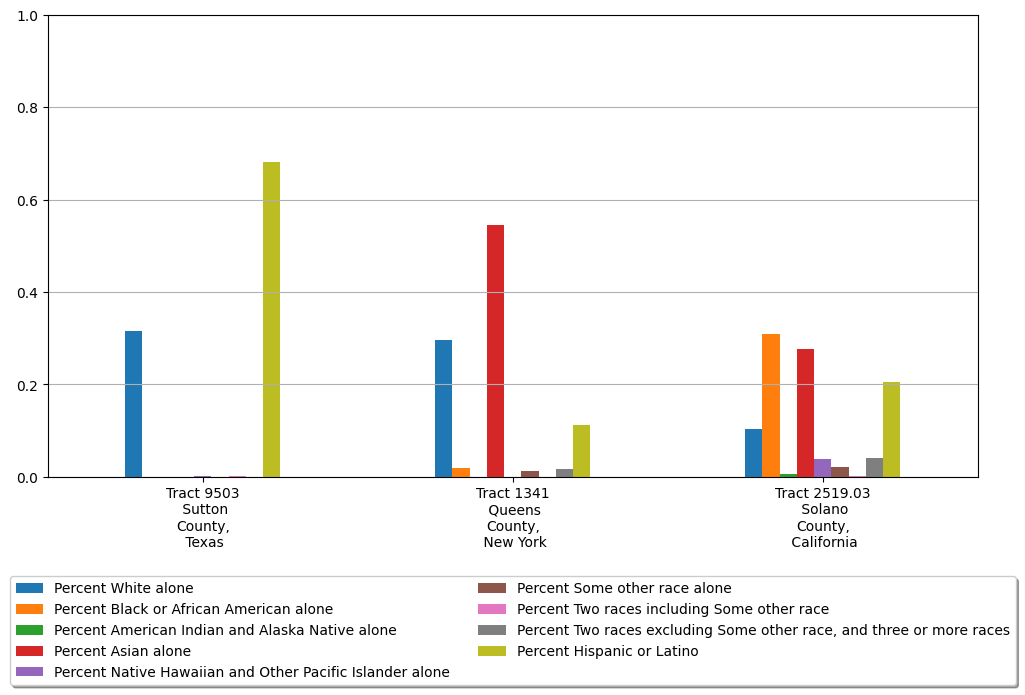

In [41]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 25% Similarity Cut

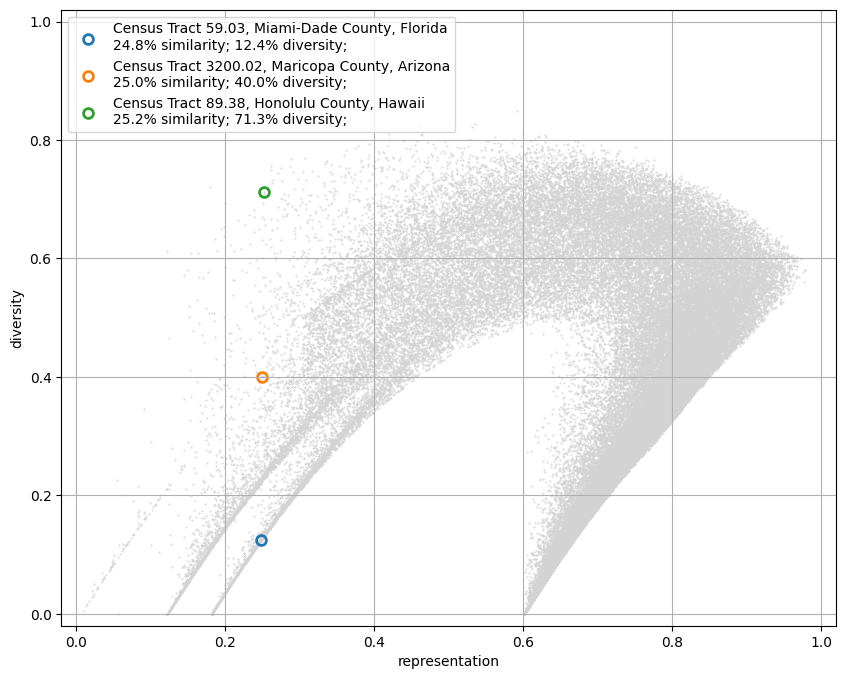

In [42]:
ax = scatter_all(df_tract)

representation = 0.25

df_max = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['representation'] > representation - 0.002) &
    (df_tract['representation'] < representation + 0.002) &
    (df_tract['diversity'] > diversity - 0.02) &
    (df_tract['diversity'] < diversity + 0.02)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

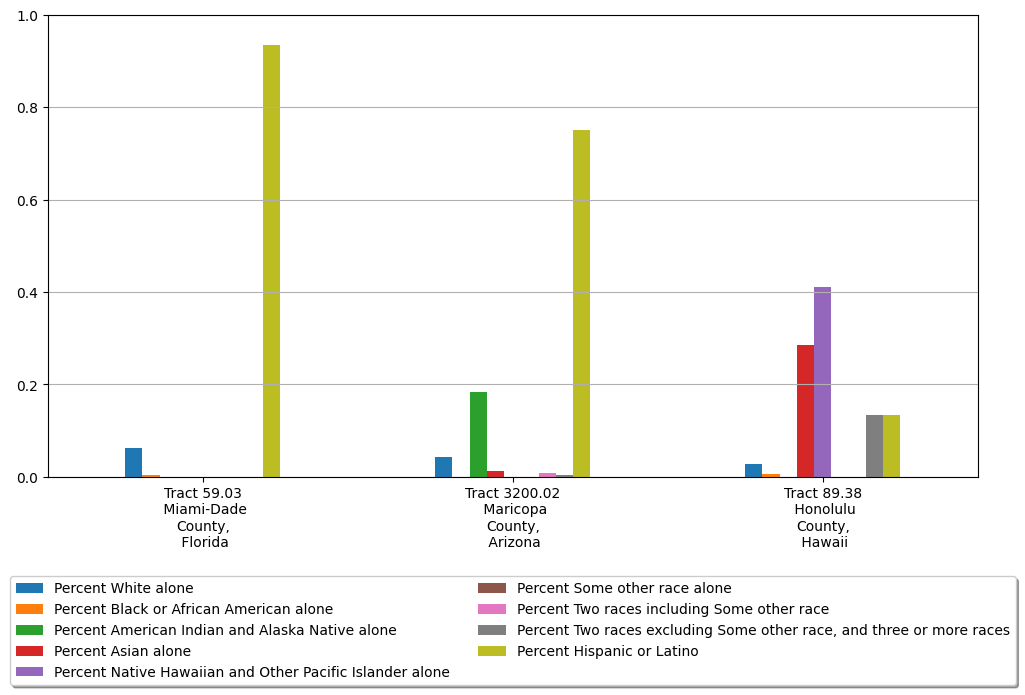

In [43]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## State-Level Samples

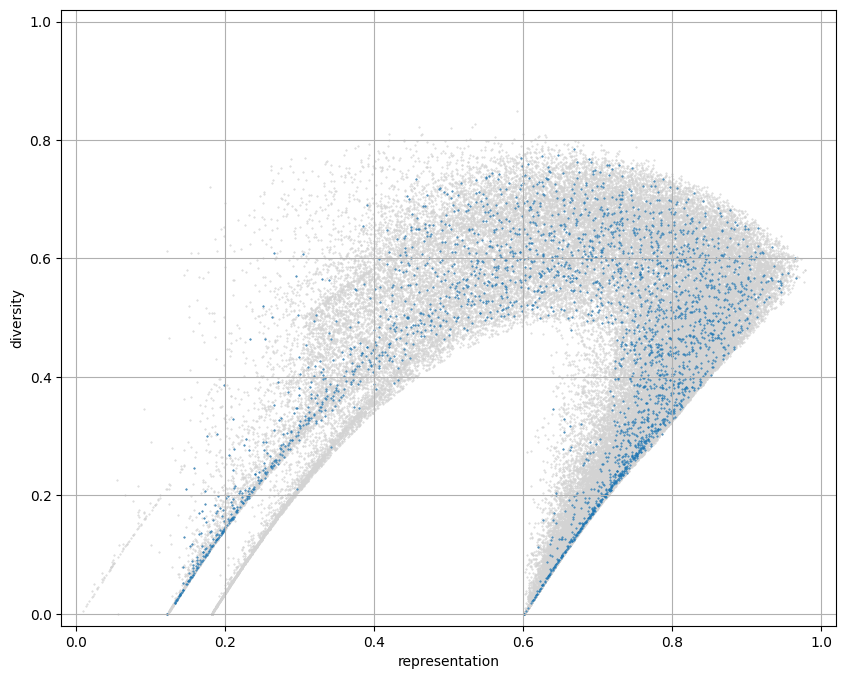

In [44]:
ax = scatter_all(df_tract)
ax = scatter_all(df_tract[df_tract['STATE'] == states.GA], color='C0', ax=ax)

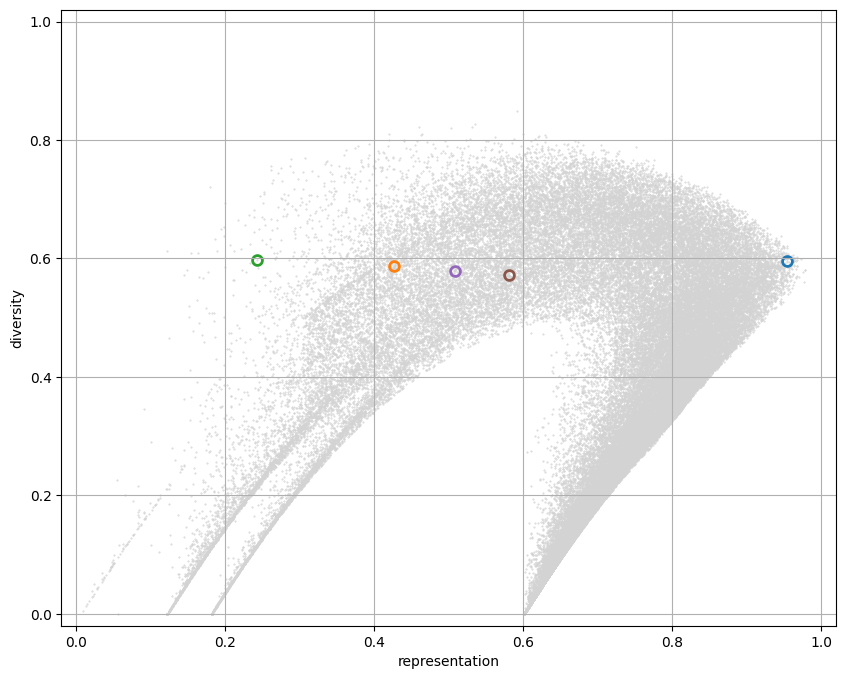

In [45]:
ax = scatter_all(df_tract)

for ii, color in graph_colors[0]:
    
    df_extreme = df_tract[df_tract[f'frac_{leaves[ii]}'] > 0.6].nlargest(
        100, 'representation'
    ).nlargest(
        1, 'diversity'
    )

    df_extreme.plot.scatter(
        'representation', 'diversity', 
        s=50, c='#0000', edgecolor=color, linewidth=2,
        ax=ax
    )

ax.grid()

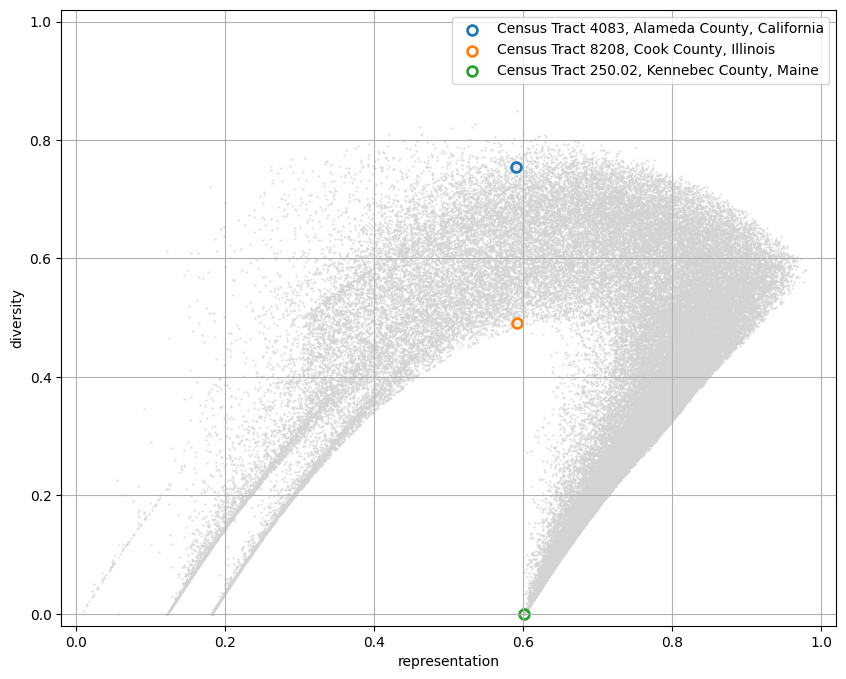

In [46]:
ax = scatter_all(df_tract)

df_0 = df_tract.nlargest(1, 'diversity')

diversity = df_0['diversity'].iloc[0]
representation = df_0['representation'].iloc[0]

df_similar_representation = df_tract[
    (df_tract['representation'] > representation - 0.0025) &
    (df_tract['representation'] < representation + 0.0025) &
    (df_tract['diversity'] < diversity)
]

df_1 = df_similar_representation[df_similar_representation[f'frac_{leaves[0]}'] < 0.2].nlargest(1, 'diversity')

name = df_1['NAME'].iloc[0]
df_1.plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C0', linewidth=2,
    label=name,
    ax=ax
)

df_2 = df_similar_representation.nsmallest(1, 'diversity')

name = df_2['NAME'].iloc[0]
df_2.plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C1', linewidth=2,
    label=name,
    ax=ax
)

df_3 = df_tract[df_tract['max_col'] == leaves[0]].nsmallest(
    1, 'diversity'
)

name = df_3['NAME'].iloc[0]
df_3.plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C2', linewidth=2,
    label=name,
    ax=ax
)

ax.grid()

In [47]:
df_selected_points = pd.concat([df_1, df_2, df_3])

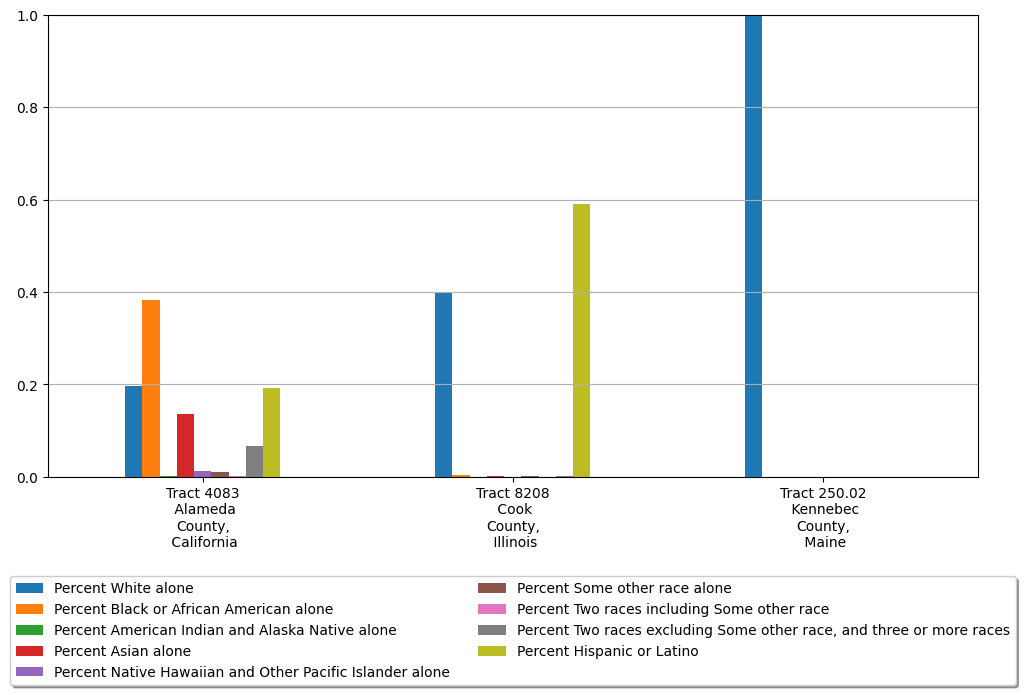

In [48]:
ax = plot_bar_selected(df_selected_points)

     representation  diversity
0.0        0.008694   0.000000
0.2        0.576918   0.171881
0.4        0.669980   0.326210
0.6        0.736179   0.473805
0.8        0.804682   0.589080
1.0        0.978420   0.848912


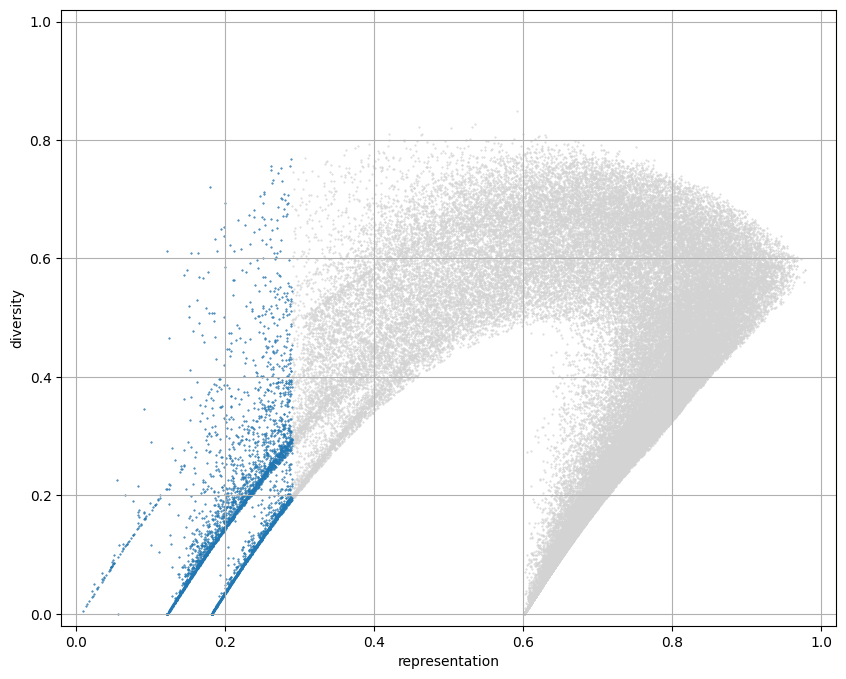

In [49]:
ax = scatter_all(df_tract)

quantiles = df_tract[['representation', 'diversity']].quantile(np.linspace(0, 1, 6))

print(quantiles)


n = len(df_tract.index)

ax = df_tract.nsmallest(5 * n // 100, 'representation').plot.scatter(
    'representation', 'diversity', s=0.2, c='C0',
    ax=ax,
)

ax.grid()

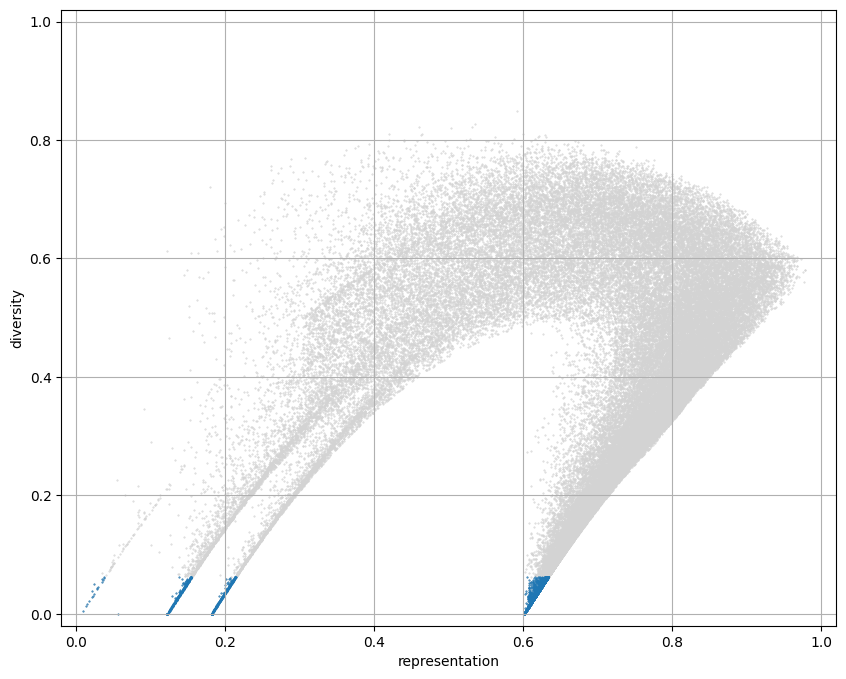

In [50]:
ax = scatter_all(df_tract)

n = len(df_tract.index)

ax = df_tract.nsmallest(5 * n // 100, 'diversity').plot.scatter(
    'representation', 'diversity', s=0.2, c='C0',
    ax=ax,
)

ax.grid()

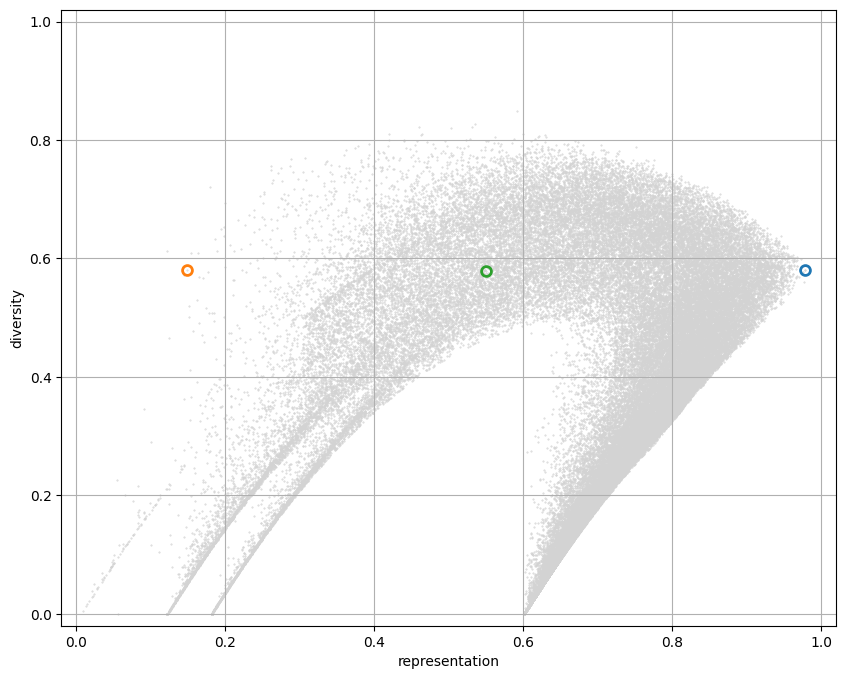

In [51]:
ax = scatter_all(df_tract)

df_max_rep = df_tract.nlargest(1, 'representation')

df_max_rep.plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C0', linewidth=2,
    ax=ax
)

diversity = df_max_rep['diversity'].iloc[0]
representation = df_max_rep['representation'].iloc[0]

df_similar_diversity = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['representation'] < representation)
]

df_similar_diversity.nsmallest(1, 'representation').plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C1', linewidth=2,
    ax=ax
)

df_similar_diversity[
    (df_similar_diversity['representation'] > 0.55)
].nsmallest(1, 'representation').plot.scatter(
    'representation', 'diversity',
    s=50, c='#0000', edgecolor='C2', linewidth=2,
    ax=ax
)

ax.grid()

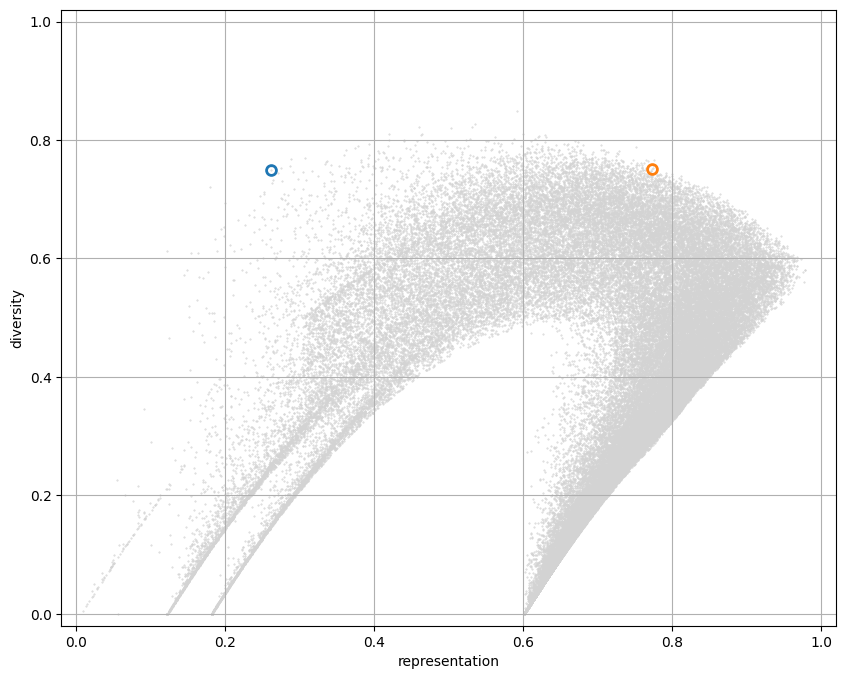

In [52]:
ax = scatter_all(df_tract)

diversity = 0.75

df_similar_diversity = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) 
]

df_similar_diversity.nsmallest(1, 'representation').plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C0', linewidth=2,
    ax=ax
)

df_similar_diversity.nlargest(1, 'representation').plot.scatter(
    'representation', 'diversity', 
    s=50, c='#0000', edgecolor='C1', linewidth=2,
    ax=ax
)

ax.grid()

In [53]:
# Top by similarity.
df_tract[df_tract[f'frac_{leaves[0]}'] > threshold].nlargest(10, 'representation')[
    ['NAME', 'total', f'frac_{leaves[0]}', f'frac_{leaves[1]}', f'frac_{leaves[3]}', f'frac_{leaves[-1]}', 'representation', 'diversity']
]

NAME  total  \
18071      Census Tract 146.01, Jackson County, Missouri   5211   
30144        Census Tract 28.07, Kern County, California   3486   
39285       Census Tract 112.09, Collier County, Florida   6514   
54942  Census Tract 128.03, Westchester County, New York   2597   
68001  Census Tract 112.02, Richland County, South Ca...   3578   
63924     Census Tract 2.03, Vanderburgh County, Indiana   3128   
84106      Census Tract 136.12, Jackson County, Missouri   6562   
55144        Census Tract 1381.07, Cuyahoga County, Ohio   1953   
80190      Census Tract 303.10, Columbia County, Georgia   3977   
60089  Census Tract 9301.01, Surry County, North Caro...   2089   

       frac_B03002_003E  frac_B03002_004E  frac_B03002_006E  frac_B03002_012E  \
18071          0.800038          0.104586          0.000000          0.084245   
30144          0.800057          0.029260          0.023523          0.144005   
39285          0.800123          0.001996          0.013202          0.173780   
54942          0.800154          0.031960          0.050828          0.104351   
68001          0.800168          0.120179          0.046115          0.018726   
63924          0.800192          0.112852          0.047634          0.039322   
84106          0.800213          0.090521          0.045718          0.043127   
55144          0.800307          0.087046          0.052227          0.048643   
80190          0.800352          0.022127          0.043249          0.115162   
60089          0.800383          0.069411          0.000000          0.127812   

       representation  diversity  
18071        0.800910   0.341829  
30144        0.800891   0.337751  
39285        0.800826   0.329307  
54942        0.800795   0.345098  
68001        0.800781   0.342592  
63924        0.800757   0.343142  
84106        0.800735   0.347097  
55144        0.800641   0.346710  
80190        0.800597   0.343528  
60089        0.800566   0.338227

In [54]:
# Most diverse among those that are mostly white.
df_tract[df_tract[f'frac_{leaves[0]}'] > threshold].nlargest(10, 'diversity')[
    ['NAME', 'total', f'frac_{leaves[0]}', f'frac_{leaves[1]}', f'frac_{leaves[3]}', f'frac_{leaves[-1]}', 'representation', 'diversity']
]

NAME  total  \
35580   Census Tract 2011.04, Cleveland County, Oklahoma   1987   
45820         Census Tract 419, Clark County, Washington   2128   
66851  Census Tract 6002.04, Bristol County, Massachu...   4407   
3492         Census Tract 68.12, Denver County, Colorado   4185   
27625  Census Tract 449.19, Riverside County, California   4907   
31602       Census Tract 9702.01, Emmet County, Michigan   2704   
5858          Census Tract 6, Lancaster County, Nebraska   6222   
13754        Census Tract 55.02, Ingham County, Michigan   6610   
52883     Census Tract 6.02, Washington County, Oklahoma   3019   
72362     Census Tract 1904.02, Suffolk County, New York   2315   

       frac_B03002_003E  frac_B03002_004E  frac_B03002_006E  frac_B03002_012E  \
35580          0.800201          0.045798          0.015098          0.039255   
45820          0.800282          0.022086          0.031955          0.046053   
66851          0.800998          0.059451          0.022918          0.055820   
3492           0.800239          0.037993          0.046834          0.066906   
27625          0.800082          0.052782          0.019156          0.079682   
31602          0.800666          0.004068          0.005178          0.002959   
5858           0.800546          0.046609          0.063967          0.047412   
13754          0.800756          0.070651          0.036762          0.028593   
52883          0.801259          0.019543          0.044717          0.029480   
72362          0.800432          0.026782          0.007343          0.041469   

       representation  diversity  
35580        0.732893   0.350360  
45820        0.736337   0.350042  
66851        0.759992   0.349839  
3492         0.779802   0.349751  
27625        0.776565   0.349656  
31602        0.650597   0.349355  
5858         0.781393   0.349278  
13754        0.764926   0.349275  
52883        0.726481   0.349004  
72362        0.705095   0.348909

In [55]:
# Most diverse among those that are mostly Black.
df_tract[df_tract[f'frac_{leaves[1]}'] > threshold].nlargest(10, 'diversity')[
    ['NAME', 'total', f'frac_{leaves[0]}', f'frac_{leaves[1]}', f'frac_{leaves[3]}', f'frac_{leaves[-1]}', 'representation', 'diversity']
]

NAME  total  \
7682            Census Tract 8271, Cook County, Illinois   2514   
7401        Census Tract 406.39, Clayton County, Georgia   3041   
9583   Census Tract 6007.03, Los Angeles County, Cali...   1709   
21342           Census Tract 734, Kings County, New York   1698   
60228             Census Tract 80, Hamilton County, Ohio   6204   
53704       Census Tract 69, Milwaukee County, Wisconsin   2209   
78499       Census Tract 58.01, Jackson County, Missouri   2138   
68987             Census Tract 115, Lake County, Indiana   2636   
61551          Census Tract 819, Volusia County, Florida   3595   
40518             Census Tract 2, Tulsa County, Oklahoma   1561   

       frac_B03002_003E  frac_B03002_004E  frac_B03002_006E  frac_B03002_012E  \
7682           0.017502          0.800318          0.054495          0.083930   
7401           0.029924          0.800723          0.076948          0.063137   
9583           0.005266          0.800468          0.015799          0.082504   
21342          0.021201          0.802120          0.000000          0.073027   
60228          0.085751          0.801741          0.000000          0.074790   
53704          0.064735          0.802626          0.000000          0.095971   
78499          0.081852          0.804022          0.000000          0.053789   
68987          0.084219          0.801214          0.000000          0.100910   
61551          0.119889          0.801391          0.000000          0.041725   
40518          0.074952          0.804612          0.012812          0.074311   

       representation  diversity  
7682         0.299228   0.348188  
7401         0.296650   0.347183  
9583         0.254591   0.344930  
21342        0.230004   0.344523  
60228        0.311228   0.343637  
53704        0.311728   0.341529  
78499        0.286081   0.341452  
68987        0.321255   0.340639  
61551        0.311203   0.340580  
40518        0.315106   0.340474

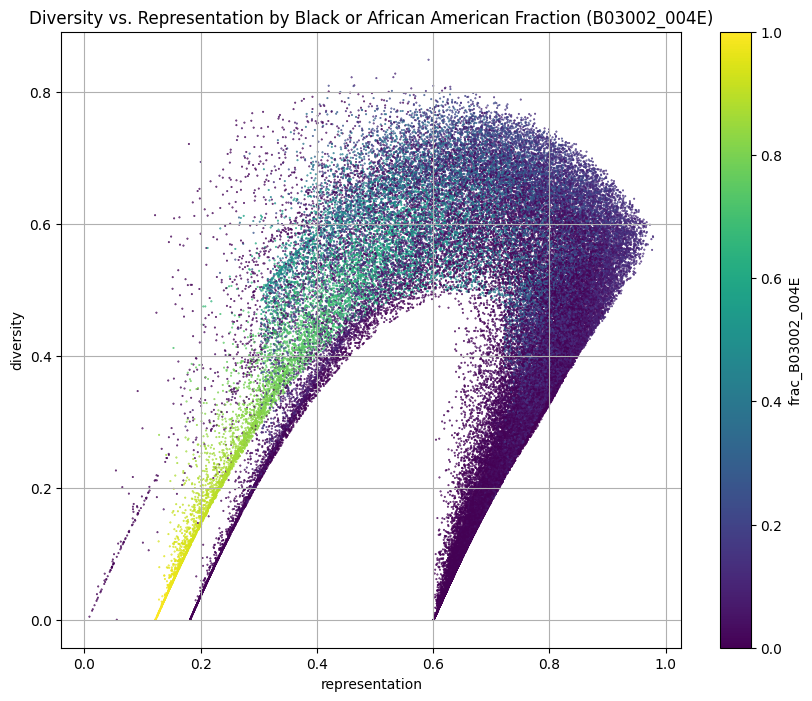

In [56]:
ax = df_tract.plot.scatter(
    'representation', 'diversity', s=0.2, c=f"frac_{leaves[1]}",
    title=f'Diversity vs. Representation by Black or African American Fraction ({leaves[1]})',
    figsize=(10, 8)
)

ax.grid()

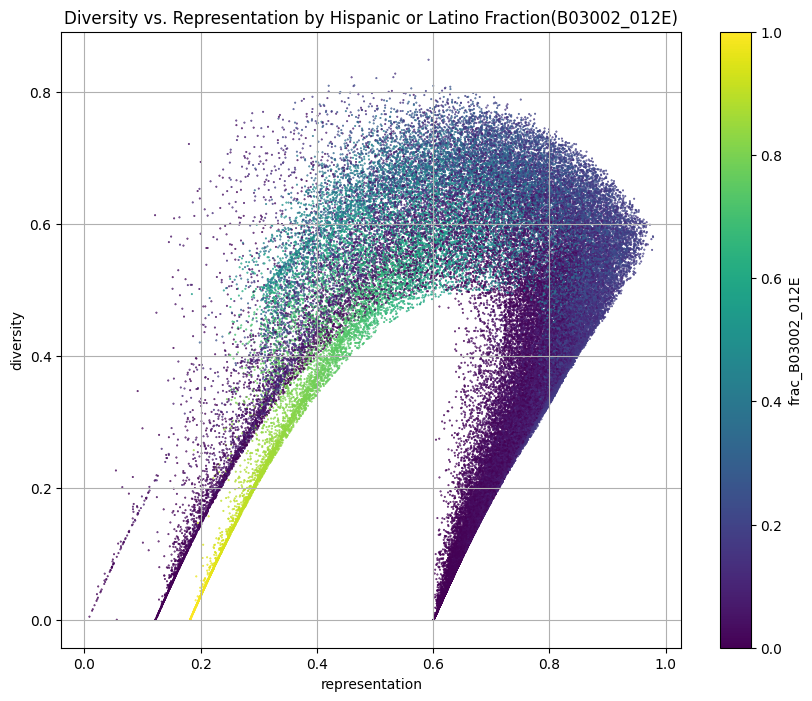

In [57]:
if HISPANIC_LATINO_VARIABLE in leaves:
    ax = df_tract.plot.scatter(
        'representation', 'diversity', s=0.2, c=f"frac_{HISPANIC_LATINO_VARIABLE}",
        title=f'Diversity vs. Representation by Hispanic or Latino Fraction({HISPANIC_LATINO_VARIABLE})',

        figsize=(10, 8)
    )

    ax.grid()

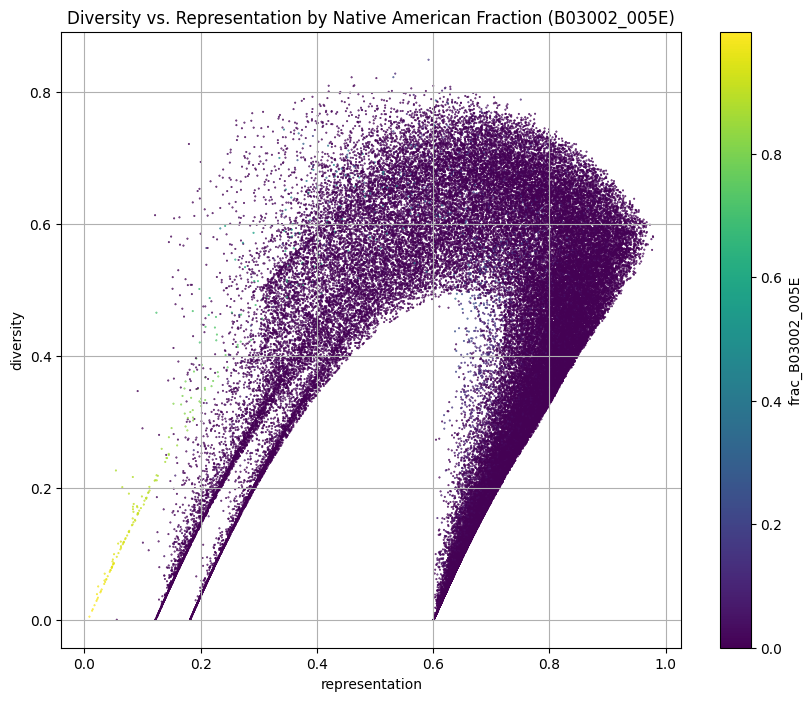

In [58]:
ax = df_tract.plot.scatter(
    'representation', 'diversity', s=0.2, c=f"frac_{leaves[2]}",
    title=f'Diversity vs. Representation by Native American Fraction ({leaves[2]})',
    figsize=(10, 8)
)

ax.grid()

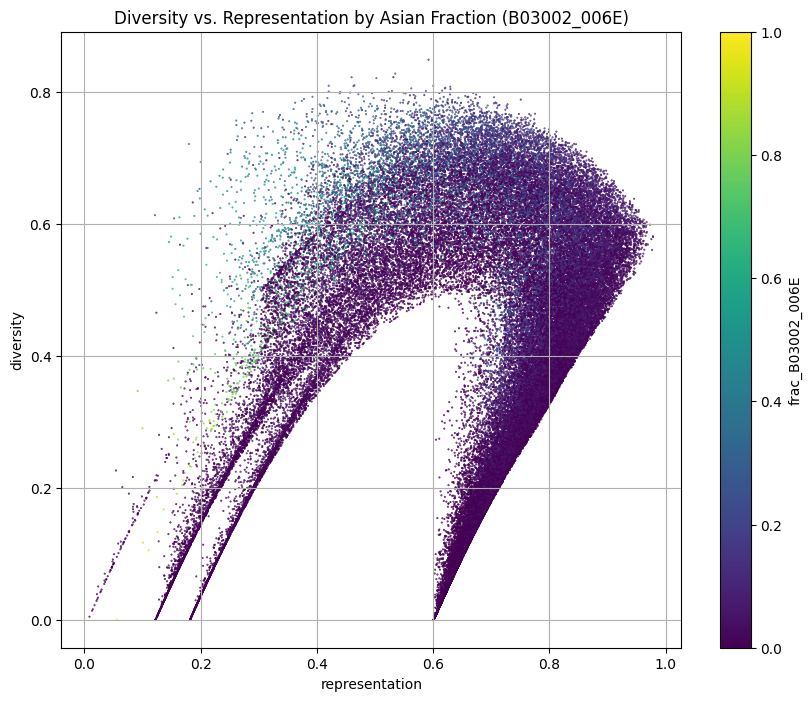

In [59]:
ax = df_tract.plot.scatter(
    'representation', 'diversity', s=0.2, c=f"frac_{leaves[3]}",
    title=f'Diversity vs. Representation by Asian Fraction ({leaves[3]})',
    figsize=(10, 8)
)

ax.grid()

# 4. Plot Maps

## Infer the geographies so we can plot

In [60]:
%%time

gdf_tract = ced.add_inferred_geography(df_tract, YEAR)

CPU times: user 10.9 s, sys: 229 ms, total: 11.1 s
Wall time: 11.2 s


## Get state boundaries for the plots

In [61]:
%%time

gdf_states = ced.download(
    DATASET,
    YEAR,
    ['NAME'],
    state=ALL_STATES_AND_DC,
    with_geometry=True
)

CPU times: user 402 ms, sys: 12.5 ms, total: 414 ms
Wall time: 1.12 s


## Plot Representation

In [62]:
gdf_states.columns

Index(['STATE', 'NAME', 'geometry'], dtype='object')

CPU times: user 6min 20s, sys: 3.4 s, total: 6min 23s
Wall time: 6min 21s


Text(0.5, 1.0, 'Representation')

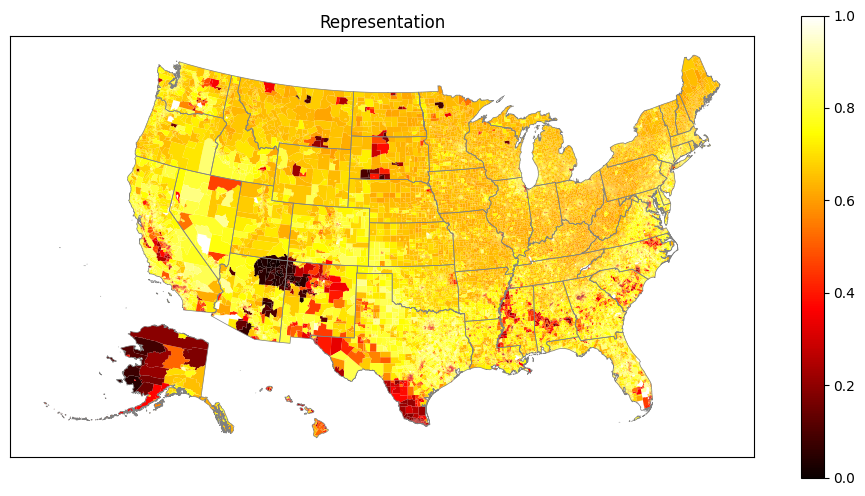

In [63]:
%%time

ax = cem.plot_us(
    gdf_tract[(gdf_tract.geometry != None)],
    'representation',
    cmap="hot",
    legend=True,
    figsize=(12, 6),
    vmin=0.0,
    vmax=1.0,
)

ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.5, ax=ax)

ax.set_title('Representation')

## Plot Diversity

CPU times: user 6min 21s, sys: 3.22 s, total: 6min 24s
Wall time: 7min 39s


Text(0.5, 1.0, 'Diversity')

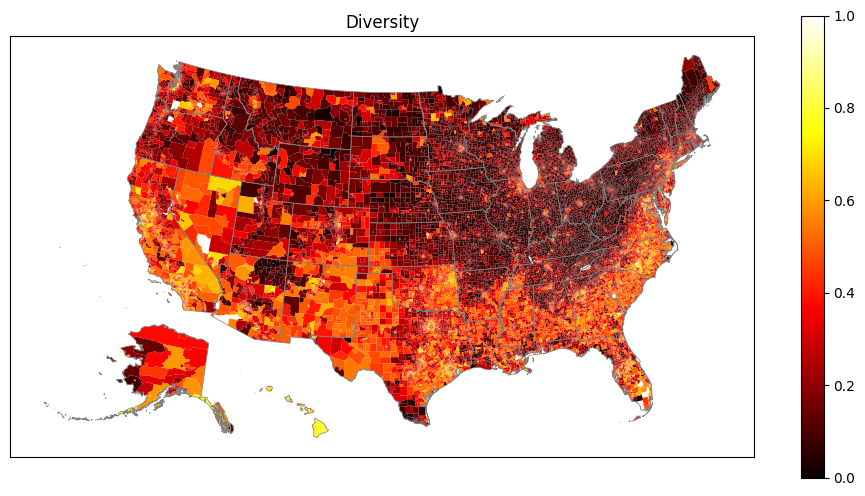

In [64]:
%%time

ax = cem.plot_us(
    gdf_tract[(gdf_tract.geometry != None)],
    'diversity',
    cmap="hot",
    legend=True,
    figsize=(12, 6),
    vmin=0.0,
    vmax=1.0,
)

ax = cem.plot_us_boundary(gdf_states, edgecolor="gray", linewidth=0.5, ax=ax)

ax.set_title('Diversity')

# Appendix

## 7. What are the top and bottom 10%?

In [65]:
%%time

n = len(gdf_tract.index)

gdf_top = gdf_tract.nlargest(n // 10, "representation")
gdf_bottom = gdf_tract.nsmallest(n // 10, "representation")

gdf_centroids = gdf_tract.copy()

gdf_random_sample = gdf_tract.sample(n=n // 10, random_state=17)

CPU times: user 34.1 ms, sys: 5.07 ms, total: 39.1 ms
Wall time: 38.1 ms


In [66]:
%%time

# Compute the geometry to centroid points to make the plot
# more readable.

gdf_top.geometry = cem.geographic_centroids(gdf_top)
gdf_bottom.geometry = cem.geographic_centroids(gdf_bottom)

gdf_centroids.geometry = cem.geographic_centroids(gdf_centroids)

gdf_random_sample.geometry = cem.geographic_centroids(gdf_random_sample)

CPU times: user 2min 48s, sys: 916 ms, total: 2min 49s
Wall time: 2min 49s


In [67]:
def plot_top_or_bottom(
    gdf,
    metric_description: str,
    top_or_bottom: str = "top",
):
    """
    A helper plot routine.

    Covers most of the repetitive boilerplate that we don't
    want to deal with typing more than once.
    """

    # Plot configuration.

    top_color = "#0343df"
    bottom_color = "#E50000"
    random_color = "#74216f"

    markersize = 1

    state_linewidth = 0.5
    state_edgecolor = "gray"

    all_color = "lightgray"

    figsize = (12, 6)

    # Actual plotting.

    # State bounds
    ax = cem.plot_us_boundary(
        gdf_states,
        edgecolor=state_edgecolor,
        linewidth=state_linewidth,
        figsize=figsize,
    )

    # All tracts in a background color
    cem.plot_us(
        gdf_centroids[gdf_centroids.geometry != None],
        markersize=markersize,
        color=all_color,
        ax=ax,
    )

    # The sample we want to emphasize
    cem.plot_us(
        gdf[gdf.geometry != None],
        markersize=markersize,
        color=top_color
        if top_or_bottom == "top"
        else (bottom_color if top_or_bottom == "bottom" else random_color),
        ax=ax,
    )

    if top_or_bottom == "top":
        ax.set_title(
            f"Top 10% Most {metric_description.title()} Census Tracts (n = {len(gdf.index)})"
        )
    elif top_or_bottom == "bottom":
        ax.set_title(
            f"Bottom 10% Least {metric_description.title()} Census Tracts (n = {len(gdf.index)})"
        )
    else:
        ax.set_title(f"Random 10% Sample of Census Tracts (n = {len(gdf.index)})")

    ax.tick_params(
        left=False,
        right=False,
        bottom=False,
        labelleft=False,
        labelbottom=False,
    )

#### Random 10% Sample

The purpose of this first plot is to show us what the distribution of a random 10%
sample looks like. Then we can see if our top and bottom 10% look at all like this
or if they are concentrated in regions according to some different kind of spatial
distribution.

In [68]:
%%time
plot_top_or_bottom(gdf_random_sample, "", top_or_bottom="random")

CPU times: user 29.6 s, sys: 2.3 s, total: 31.9 s
Wall time: 29.1 s


CPU times: user 29.5 s, sys: 2.04 s, total: 31.5 s
Wall time: 28.8 s


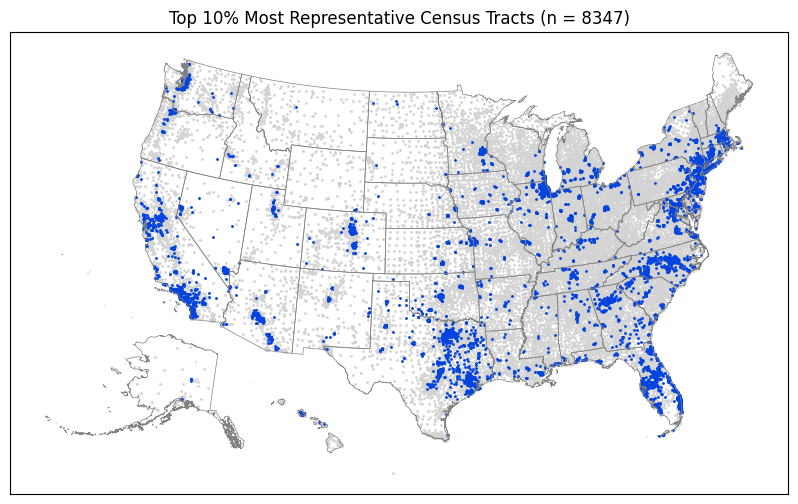

In [69]:
%%time
plot_top_or_bottom(gdf_top, "Representative")

CPU times: user 29.5 s, sys: 2.23 s, total: 31.8 s
Wall time: 28.9 s


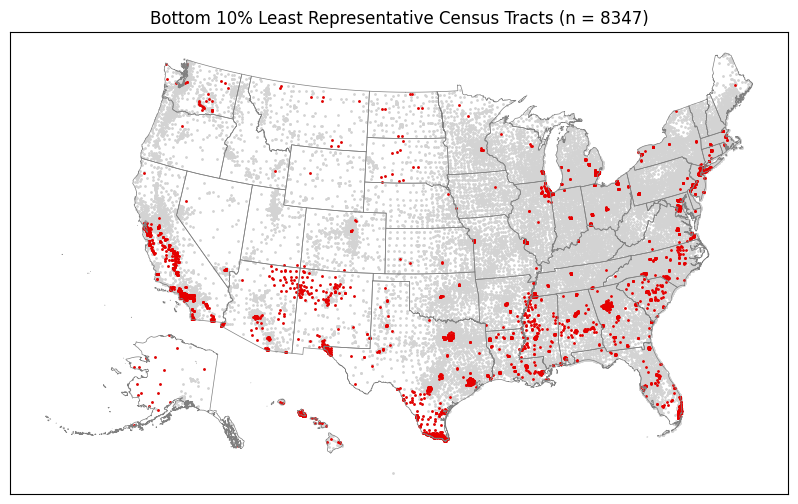

In [70]:
%%time
plot_top_or_bottom(gdf_bottom, "Representative", top_or_bottom="bottom")

In [71]:
from queue import PriorityQueue

q = PriorityQueue()

q.put((1, 'a'))
q.put((0, 'b'))
q.put((2, 'c'))

q.get()

(0, 'b')

In [72]:
import divintseg as dis

In [73]:
print(df_us)

  US  B03002_003E  B03002_004E  B03002_005E  B03002_006E  B03002_007E  \
0  1    196251375     39994653      2075852     18184182       550080   

   B03002_008E  B03002_010E  B03002_011E  B03002_012E  
0      1017604       827762      8306780     59361020  
